# model

In [17]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from lightgbm import LGBMRegressor, plot_importance
from sklearn.metrics import roc_auc_score

In [18]:
# knob 종류 및 바운드

knobs_rdb = {
    
    "hash-max-ziplist-entries":     (256, 751), 
    "hash-max-ziplist-value": (16, 257),
    "activerehashing": ('yes', 'no'),  ##yes
    "hz": (1, 41),
    "dynamic-hz": ('yes', 'no'),

    "save0_0": (700,1100),
    "save0_1": (1,9),
    "save1_0": (100,500),
    "save1_1": (10,100),
    "save2_0": (30,90),
    "save2_1": (8000,12000),

    "rdbcompression": ('yes', 'no'), ##yes
    "rdbchecksum": ('yes', 'no'),    ##yes
    "rdb-save-incremental-fsync": ('yes', 'no'),   ## yes

    "activedefrag": ('yes','no'),  
    "active-defrag-threshold-lower": (1, 31),
    "active-defrag-threshold-upper": (70, 101),
    "active-defrag-cycle-min": (1, 31),
    "active-defrag-cycle-max": (70, 91),
    
    "maxmemory": (1000, 2900),   ##"volatile-lru"
    "maxmemory-policy":     ("volatile-lru", "allkeys-lru", "volatile-lfu", "allkeys-lfu", 
                             "volatile-random","allkeys-random", "volatile-ttl", "noeviction"),
    "maxmemory-samples": (3, 7),
    
    "lazyfree-lazy-eviction": ('yes', 'no'),
    "lazyfree-lazy-expire": ('yes', 'no'),
    "lazyfree-lazy-server-del": ('yes', 'no')
}

knobs_list = list(knobs_rdb.keys())
knobs_bound = list(knobs_rdb.values())

## 데이터 전처리
* 이상치 파악
* test, train 데이터 잘 나뉘어졌는지 확인

In [19]:
# config(knob) data
config_df = pd.read_csv("./data/result_config5.csv", sep=',')

# external(throughput) data
external_df = pd.read_csv("./data/external_metrics5.csv", sep=',')

In [20]:
# config(knog), external(throughput) 데이터 하나의 프레임으로 결합
dataset = config_df
dataset['throughput'] = external_df['Gets_KB/sec']

In [21]:
dataset.head(3)

,appendonly,appendfsync,auto-aof-rewrite-percentage,auto-aof-rewrite-min-size,no-appendfsync-on-rewrite,aof-rewrite-incremental-fsync,aof-use-rdb-preamble,save0_0,save0_1,save1_0,...,maxmemory-samples,lazyfree-lazy-eviction,lazyfree-lazy-expire,lazyfree-lazy-server-del,hash-max-ziplist-entries,hash-max-ziplist-value,activerehashing,hz,dynamic-hz,throughput
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,868,4,320,...,5,yes,yes,yes,506,144,no,20,yes,45305.88
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,867,6,258,...,4,yes,no,yes,552,141,no,22,yes,44540.19
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,911,6,319,...,5,yes,no,yes,552,185,yes,20,no,45261.71


In [22]:
# 결측치 처리 
dataset_nan = dataset.copy()
dataset['activedefrag'].fillna(value='no', inplace=True)  # activedefrag no 채우기
dataset = dataset.fillna(value = 0)  # 전부 0으로 채움

In [23]:
# maxmemory knob 단위(mb) 처리
dataset['maxmemory']  = dataset['maxmemory'].str.strip('mb')
dataset['maxmemory'] = pd.to_numeric(dataset['maxmemory'])

In [24]:
# Object 변수 categorical 로 변경 (LightGBM에 바로 넣기 위해)
category_knob = []

for knob in dataset:
    if dataset[knob].dtype == 'O':  # Object인 경우 category 형으로 변경
        dataset[knob] = dataset[knob].astype('category')
        if knob in knobs_list:
            category_knob.append(knob)

In [25]:
# 설정한 knob들만 추출
extract_knobs_list = knobs_list.copy()
extract_knobs_list.append('throughput')  # target 값 추가

dataset = dataset[extract_knobs_list]

In [26]:
# 결측치 처리전 확인
print(dataset_nan.info())

# 결측치 처리후 확인
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   appendonly                     0 non-null      float64
 1   appendfsync                    0 non-null      float64
 2   auto-aof-rewrite-percentage    0 non-null      float64
 3   auto-aof-rewrite-min-size      0 non-null      float64
 4   no-appendfsync-on-rewrite      0 non-null      float64
 5   aof-rewrite-incremental-fsync  0 non-null      float64
 6   aof-use-rdb-preamble           0 non-null      float64
 7   save0_0                        1700 non-null   int64  
 8   save0_1                        1700 non-null   int64  
 9   save1_0                        1700 non-null   int64  
 10  save1_1                        1700 non-null   int64  
 11  save2_0                        1700 non-null   int64  
 12  save2_1                        1700 non-null   i

### 이상치 처리

In [27]:
# -999999와 같은 이상치 확인 -> 없음
dataset.describe()

,hash-max-ziplist-entries,hash-max-ziplist-value,hz,save0_0,save0_1,save1_0,save1_1,save2_0,save2_1,active-defrag-threshold-lower,active-defrag-threshold-upper,active-defrag-cycle-min,active-defrag-cycle-max,maxmemory,maxmemory-samples,throughput
count,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000
mean,503.073529,136.014118,20.331765,899.707647,5.018824,301.504118,54.734706,60.100588,10003.781176,7.648235,41.854118,7.588824,39.392353,1938.529412,4.999412,44384.915482
std,40.678152,20.991291,3.175918,33.353880,0.747528,33.671656,7.505045,5.084096,337.575574,7.950170,42.548603,7.905846,40.028266,571.372337,0.362289,2836.074574
min,365.000000,68.000000,9.000000,792.000000,2.000000,200.000000,30.000000,44.000000,8680.000000,0.000000,0.000000,0.000000,0.000000,1000.000000,4.000000,26918.970000
25%,476.000000,122.000000,18.000000,877.000000,5.000000,278.000000,50.000000,57.000000,9781.500000,0.000000,0.000000,0.000000,0.000000,1500.000000,5.000000,42970.870000
50%,503.000000,135.000000,20.000000,899.000000,5.000000,302.000000,55.000000,60.000000,9999.500000,0.000000,0.000000,0.000000,0.000000,1900.000000,5.000000,44181.360000
75%,531.000000,150.000000,22.000000,922.000000,5.000000,325.000000,60.000000,63.000000,10229.000000,15.000000,85.000000,15.000000,80.000000,2400.000000,5.000000,45033.152500
max,635.000000,204.000000,33.000000,1016.000000,7.000000,413.000000,78.000000,75.000000,11169.000000,23.000000,93.000000,23.000000,85.000000,2900.000000,6.000000,64115.000000


<AxesSubplot:>

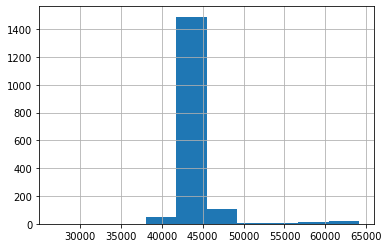

In [28]:
# 이상치 파악 
dataset['throughput'].hist()

In [29]:
# 인덱스제거하고 돌려보자
print(dataset['throughput'][dataset['throughput'] <= 52500])
outlier_index = dataset['throughput'][dataset['throughput'] <= 52500].index
print('개수: ', len(outlier_index))

0       45305.88
1       44540.19
2       45261.71
3       45108.96
4       45277.43
          ...   
1695    44861.25
1696    45034.29
1697    45003.06
1698    44653.27
1699    44799.15
Name: throughput, Length: 1655, dtype: float64
개수:  1655


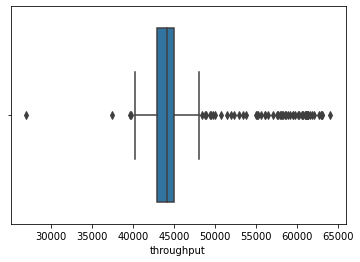

In [30]:
# 이상치로 분류되진 않지만 제거한다. 
import seaborn as sns
sns.boxplot(x = "throughput",data = dataset )
plt.show()

In [31]:
# # 이상치 제거
# dataset = dataset.drop(outlier_index)

In [32]:
# 이상치 제거 확인
dataset.shape

(1700, 26)

### test, train 데이터 분리

In [107]:
# test, train 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:,:-1]
                                                    , dataset['throughput'] 
                                                    ,test_size=0.2
                                                   , random_state = 156)


In [108]:
# X_train 확인
X_train.head()

,hash-max-ziplist-entries,hash-max-ziplist-value,activerehashing,hz,dynamic-hz
1658,672,180,yes,5,no
1286,596,202,no,25,yes
1709,547,127,yes,16,yes
1166,642,28,no,33,no
2258,293,90,yes,31,yes


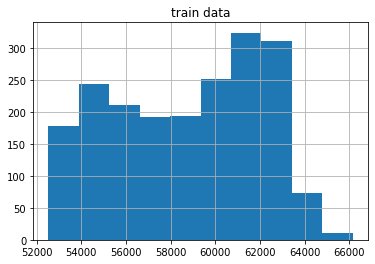

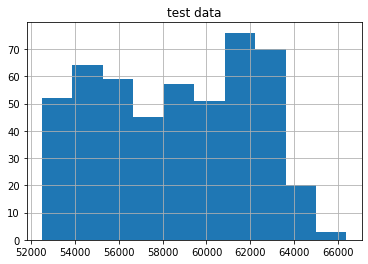

In [109]:
# test, train 에 비슷하게 분류됬는지 확인
y_train.hist()
plt.title('train data')
plt.show()

y_test.hist()
plt.title('test data')
plt.show()

## LightGBM 모델 생성

In [110]:
# 모델 객체 생성, n_estimators = 400으로 설정
lgbm_wrapper = LGBMRegressor(n_estimators=1000, learning_rate=0.1)

# 검증 데이터(validation data)
evals = [(X_test, y_test)]

lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc',
                eval_set = evals, verbose = True)

/Users/joseong-un/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/joseong-un/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's auc: 1	valid_0's l2: 1.14983e+07
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 1	valid_0's l2: 1.15109e+07
[3]	valid_0's auc: 1	valid_0's l2: 1.15199e+07
[4]	valid_0's auc: 1	valid_0's l2: 1.15248e+07
[5]	valid_0's auc: 1	valid_0's l2: 1.15619e+07
[6]	valid_0's auc: 1	valid_0's l2: 1.15602e+07
[7]	valid_0's auc: 1	valid_0's l2: 1.15746e+07
[8]	valid_0's auc: 1	valid_0's l2: 1.16181e+07
[9]	valid_0's auc: 1	valid_0's l2: 1.16383e+07
[10]	valid_0's auc: 1	valid_0's l2: 1.16665e+07
[11]	valid_0's auc: 1	valid_0's l2: 1.16701e+07
[12]	valid_0's auc: 1	valid_0's l2: 1.17014e+07
[13]	valid_0's auc: 1	valid_0's l2: 1.17219e+07
[14]	valid_0's auc: 1	valid_0's l2: 1.17071e+07
[15]	valid_0's auc: 1	valid_0's l2: 1.16999e+07
[16]	valid_0's auc: 1	valid_0's l2: 1.17257e+07
[17]	valid_0's auc: 1	valid_0's l2: 1.17117e+07
[18]	valid_0's auc: 1	valid_0's l2: 1.1712e+07
[19]	valid_0's auc: 1	valid_0's l2: 1.1735e+07
[20]	valid_0's auc: 1	valid_0's l2: 1

LGBMRegressor(n_estimators=1000)

In [111]:
preds = lgbm_wrapper.predict(X_test)  # 예측 결과
# pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]  # 예측 확률
preds

array([58826.80826505, 58692.64373492, 58778.24868584, 58778.24868584,
       58687.98092326, 58717.10182951, 58815.41910226, 58611.67515675,
       58729.05281268, 58729.05281268, 58882.6348665 , 58817.1781994 ,
       58674.12036658, 58579.73925029, 58729.05281268, 58654.02008525,
       58841.35484087, 58756.23790981, 58729.67027327, 58611.67515675,
       58756.23790981, 58793.62210881, 58841.35484087, 58793.62210881,
       58729.05281268, 58793.62210881, 58692.64373492, 58793.62210881,
       58841.35484087, 58579.73925029, 58774.17338441, 58793.62210881,
       58654.02008525, 58729.67027327, 58774.17338441, 58927.37225652,
       58882.6348665 , 58729.67027327, 58692.64373492, 58815.41910226,
       58755.49891882, 58817.1781994 , 58817.1781994 , 58793.62210881,
       58825.91646389, 58674.12036658, 58689.92943783, 58516.29044213,
       58551.40323977, 58611.67515675, 58689.92943783, 58729.67027327,
       58729.67027327, 58729.67027327, 58882.6348665 , 58793.62210881,
      

In [112]:
X_test.iloc[:1,:]

,hash-max-ziplist-entries,hash-max-ziplist-value,activerehashing,hz,dynamic-hz
358,569,69,no,30,no


In [113]:
lgbm_wrapper.predict(X_test.iloc[3:4,:])

array([58778.24868584])

In [114]:
df_result_test2

,hash-max-ziplist-entries,hash-max-ziplist-value,activerehashing,hz,dynamic-hz,save0_0,save0_1,save1_0,save1_1,save2_0,...,active-defrag-threshold-lower,active-defrag-threshold-upper,active-defrag-cycle-min,active-defrag-cycle-max,maxmemory,maxmemory-policy,maxmemory-samples,lazyfree-lazy-eviction,lazyfree-lazy-expire,lazyfree-lazy-server-del
0,0,,,,,100,100,,0,0,...,,,,0,0,,0,,no,


In [115]:
# lgbm_wrapper.predict(df_result_test2)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

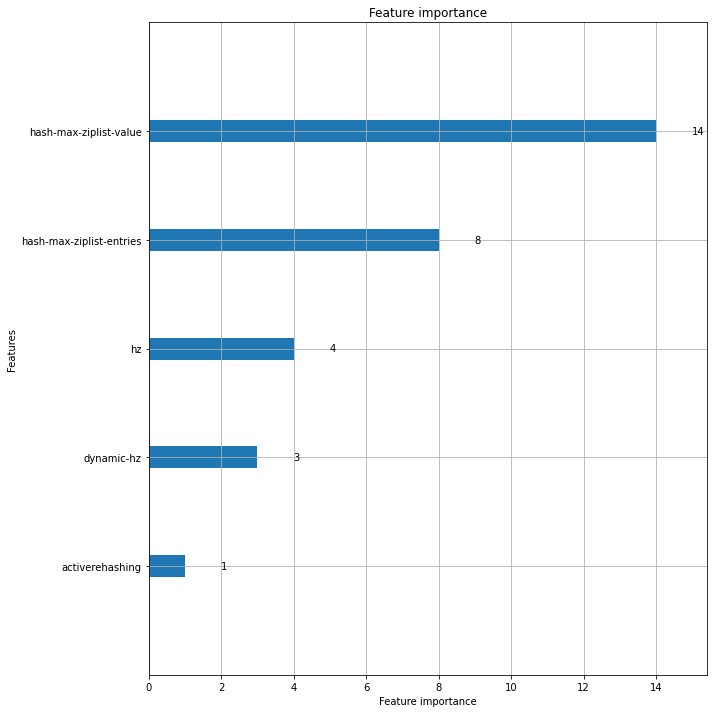

In [116]:
# plot_importance()를 이영해 피처 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax= ax)

In [117]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mse = mean_squared_error(y_test ,preds)
mse

11498283.461579042

### 하이퍼파라미터 튜닝

In [118]:
# from sklearn.model_selection import GridSearchCV

# # 하이퍼파라미터 튜닝시 수행 속도를 향상시키기 위해 n_estimators를 200으로 감소
# lgbm_wrapper = LGBMRegressor(n_estimators = 200)

# params = {
#     'num_leaves':[32, 64],
#     'max_depth':[128, 160],
#     'min_child_samples':[60, 100],
#     'subsample':[0.8, 1]
# }

# # cv는 3으로 가정 (교차 검증을 자동으로 해주는건가?)
# gridcv = GridSearchCV(lgbm_wrapper, param_grid = params, cv=3)
# gridcv.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric='auc', 
#           eval_set = [(X_train, y_train), (X_test, y_test)])

# print('GridSeaerchCV 최적 파라미터:', gridcv.best_params_)

In [119]:
# # 하이퍼 파라미터 적용 후 다시 생성
# lgbm_wrapper = LGBMRegressor(n_estimators = 1000,
#                             num_leaves = 32,
#                             subsample=0.8,
#                             min_child_samples=60,
#                             max_depth=128)

# evals = [(X_test, y_test)]

# lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100,
#                 eval_metric='auc',
#                 eval_set=evals,
#                 verbose=True)

---

# BO

## 목적함수

In [120]:
noise_level = 0.1

def objective_func(knob_value, noise_level=noise_level):
    knob_dict = {}

    for i, knob in enumerate(knobs_list): # 딕셔너리로 이동
        knob_dict[knob] = knob_value[i]
    
#     # 고정

#     knob_dict['hash-max-ziplist-entries'] =305
#     knob_dict['hash-max-ziplist-value'] =157
#     knob_dict['activerehashing'] ='yes'
#     knob_dict['hz'] = 32
#     knob_dict['dynamic-hz'] ='yes'
#     knob_dict['save0_0'] = 722
#     knob_dict['save0_1'] = 5
#     knob_dict['save1_0'] = 475
#     knob_dict['save1_1'] =12
#     knob_dict['save2_0'] = 82
#     knob_dict['save2_1'] =9163
#     knob_dict['rdbcompression'] = 'no'
#     knob_dict['rdbchecksum'] = 'no'
#     knob_dict['rdb-save-incremental-fsync'] = 'no'
#     knob_dict['active-defrag-threshold-lower'] = 13
#     knob_dict['active-defrag-threshold-upper'] = 72
#     knob_dict['active-defrag-cycle-min'] = 2
#     knob_dict['active-defrag-cycle-max'] = 73
#     knob_dict['maxmemory'] = 1221
#     knob_dict["maxmemory-policy"] = 'allkeys-random'
#     knob_dict['maxmemory-samples'] =3
#     knob_dict['lazyfree-lazy-eviction'] = 'no'
#     knob_dict['lazyfree-lazy-expire'] = 'yes'
#     knob_dict['lazyfree-lazy-server-del'] = 'no'
        
    if 'activedefrag' in knob_dict:
        if knob_dict['activedefrag'] == 'no':  # activedefrag no인 경우 나머지 관련 knob들에 0할당!
            activ_var = ['active-defrag-threshold-lower', 'active-defrag-threshold-upper', 'active-defrag-cycle-min', 'active-defrag-cycle-max']
            for activ_knob in activ_var:
                knob_dict[activ_knob] = 0     
    
    knob_df = pd.DataFrame(knob_dict, index=[0])  # 데이터 프레임으로 변환
    
    # 카테고리 변수 변경
    for knob in category_knob:
        knob_df[knob] = knob_df[knob].astype('category') 

    return -lgbm_wrapper.predict(knob_df)[0]




## gp_minimize

In [121]:
%matplotlib inline
print(__doc__)

import numpy as np
np.random.seed(237)
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process
from skopt import gp_minimize

Automatically created module for IPython interactive environment


In [122]:
res = gp_minimize(objective_func,                  # the function to minimize
                  knobs_bound,      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=50,         # the number of evaluations of f
                  n_random_starts=20,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=1234)   # the random seed

In [123]:
res.x

[308, 257, 'yes', 14, 'yes']

In [124]:
res.x_iters # 

[[502, 213, 'yes', 32, 'yes'],
 [331, 64, 'yes', 7, 'no'],
 [262, 133, 'no', 33, 'no'],
 [284, 123, 'no', 13, 'no'],
 [621, 230, 'yes', 6, 'no'],
 [480, 146, 'yes', 20, 'no'],
 [538, 250, 'no', 23, 'no'],
 [442, 95, 'yes', 27, 'no'],
 [749, 182, 'yes', 38, 'yes'],
 [453, 79, 'no', 32, 'yes'],
 [296, 186, 'no', 2, 'no'],
 [491, 32, 'no', 6, 'yes'],
 [634, 106, 'no', 37, 'yes'],
 [563, 67, 'no', 27, 'yes'],
 [588, 95, 'no', 1, 'no'],
 [617, 252, 'yes', 41, 'yes'],
 [725, 157, 'yes', 8, 'no'],
 [720, 189, 'no', 36, 'no'],
 [341, 48, 'no', 2, 'yes'],
 [643, 80, 'no', 8, 'no'],
 [504, 254, 'yes', 40, 'yes'],
 [507, 175, 'yes', 32, 'yes'],
 [476, 234, 'yes', 35, 'yes'],
 [504, 253, 'yes', 40, 'yes'],
 [504, 227, 'yes', 7, 'yes'],
 [450, 257, 'yes', 6, 'yes'],
 [503, 232, 'yes', 41, 'yes'],
 [499, 231, 'yes', 2, 'yes'],
 [482, 220, 'yes', 41, 'yes'],
 [525, 251, 'no', 31, 'yes'],
 [522, 249, 'yes', 39, 'yes'],
 [485, 249, 'yes', 35, 'yes'],
 [497, 257, 'no', 22, 'yes'],
 [484, 233, 'no', 38, 

In [125]:
res.func_vals

array([-58896.75453992, -58579.73925029, -58793.62210881, -58778.24868584,
       -58729.67027327, -58793.62210881, -58729.67027327, -58579.73925029,
       -58815.41910226, -58756.23790981, -58825.91646389, -58729.05281268,
       -58551.40323977, -58756.23790981, -58717.10182951, -58729.67027327,
       -58793.62210881, -58815.41910226, -58674.12036658, -58717.10182951,
       -58896.75453992, -58692.64373492, -58896.75453992, -58896.75453992,
       -58896.75453992, -58687.98092326, -58896.75453992, -58896.75453992,
       -58896.75453992, -58729.67027327, -58729.67027327, -58896.75453992,
       -58896.75453992, -58896.75453992, -58896.75453992, -58896.75453992,
       -58797.43238614, -58896.75453992, -58825.91646389, -58927.37225652,
       -58611.67515675, -58927.37225652, -58927.37225652, -58927.37225652,
       -58927.37225652, -58927.37225652, -58927.37225652, -58927.37225652,
       -58927.37225652, -58927.37225652])

In [126]:
res.fun

-58927.372256519615

---

In [127]:
# gp 결과 정리 함수
def li_to_str(result_list):
    for idx,knob in enumerate(list(knobs_rdb.keys())):  # knobs_rdb 키마다 접근
        print("{} ".format(knob), end='')
        print('{}'.format(result_list[idx]))

In [128]:
# gp 결과
li_to_str(res.x)

hash-max-ziplist-entries 308
hash-max-ziplist-value 257
activerehashing yes
hz 14
dynamic-hz yes


## gp 결과 정리

### gp 분류된것
"hash-max-ziplist-entries" : 284
'hash-max-ziplist-value' 22
'activerehashing': 'yes'
'hz' 32
'dynamic-hz' : 'yes'
'save0_0' : 877
'save0_1'2
'save1_0'272
'save1_1' : 12
'save2_0'33
'save2_1' : 11669 
'rdbcompression'no
'rdbchecksum' yes
"rdb-save-incremental-fsync" 'no'
'active-defrag-threshold-lower'3
'active-defrag-threshold-upper': 87
'active-defrag-cycle-min' : 25
'active-defrag-cycle-max' : 80
'maxmemory'1298
maxmemory-policy : 'allkeys-random' 
'maxmemory-samples'6
"lazyfree-lazy-eviction"  'no'
'lazyfree-lazy-expire' yes
'lazyfree-lazy-server-del' yes


### gp 분류된것2
hash-max-ziplist-entries 502
hash-max-ziplist-value 213
activerehashing yes
hz 32
dynamic-hz yes
save0_0 760
save0_1 3
save1_0 426
save1_1 24
save2_0 37
save2_1 8052 
rdbcompression no
rdbchecksum' no
rdb-save-incremental-fsync yes
active-defrag-threshold-lower 4
active-defrag-threshold-upper 72
active-defrag-cycle-min 14
active-defrag-cycle-max 70
maxmemory 1552
maxmemory-policy allkeys-random
maxmemory-samples 6
lazyfree-lazy-eviction yes
lazyfree-lazy-expire yes
lazyfree-lazy-server-del no
[575,
 94,
 'no',
 10,
 'yes',
 1072,
 5,
 465,
 24,
 83,
 9398,
 'yes',
 'yes',
 'no',
 26,
 81,
 20,
 75,
 1539,
 'allkeys-lfu',
 4,
 'yes',
 'no',
 'no']

### gp_T
hash-max-ziplist-entries 575
hash-max-ziplist-value 94
activerehashing no
hz 10
dynamic-hz yes
save0_0 1072
save0_1 5
save1_0 465
save1_1 24
save2_0 83
save2_1 9398
rdbcompression yes
rdbchecksum yes
rdb-save-incremental-fsync no
active-defrag-threshold-lower 26
active-defrag-threshold-upper 81
active-defrag-cycle-min 20
active-defrag-cycle-max 75
maxmemory 1539
maxmemory-policy allkeys-lfu
maxmemory-samples 4
lazyfree-lazy-eviction yes
lazyfree-lazy-expire no
lazyfree-lazy-server-del no

